In [754]:
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfTransformer
import enchant
import matplotlib as mpl
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import datetime as dt #datetime for timeseries support
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
import spacy
from spacy.lang.en import English
from itertools import islice
from spacy_ngram import NgramComponent
import string 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
import gensim
import emoji
import ast
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, calinski_harabasz_score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part A - Getting the data with API

In [ ]:
api_key='private key :)'

In [ ]:
cat_lst=['Music','Movies']

In [ ]:
response

In [ ]:
def get_youtube_videos(api_key, category, max_results=50):
    # יצירת שירות YouTube Data API v3
    youtube = build('youtube', 'v3', developerKey=api_key)
    # רשימה ריקה לאחסון נתוני סרטונים
    videos = []
    for cat in category:
        # ביצוע בקשה ל-API
        request = youtube.search().list(part='snippet',q=cat,maxResults=max_results)
        # קבלת תגובת API
        response = request.execute()
        # הוספת נתוני סרטונים לרשימה
        for item in range(len(response['items'])):
            if response['items'][item]['id']['kind'] == 'youtube#video':
                key= response['items'][item]['id']['videoId']
            elif response['items'][item]['id']['kind'] == 'youtube#channel':
                key= response['items'][item]['id']['channelId']
            videos.append({
            'Id': key,
            'title': response['items'][item]['snippet']['title'],
            'date': response['items'][item]['snippet']['publishedAt']
                        })
        # דפדוף בכל הדפים הבאים
        while 'nextPageToken' in response:
        # קבלת הדף הבא של תוצאות
            next_page_token = response['nextPageToken']
            request = youtube.search().list(
               part='snippet',
              q=cat,
              maxResults=max_results,
              pageToken=next_page_token
            )
            response = request.execute()
            # הוספת נתוני סרטונים לרשימה
            for item in range(len(response['items'])):
                if response['items'][item]['id']['kind'] == 'youtube#video':
                    key= response['items'][item]['id']['videoId']
                elif response['items'][item]['id']['kind'] == 'youtube#channel':
                    key= response['items'][item]['id']['channelId']
                videos.append({
                    'Id': key,
                    'title': response['items'][item]['snippet']['title'],
                    'date': response['items'][item]['snippet']['publishedAt']
                    })
                    
    # יצירת DataFrame של Pandas
    df = pd.DataFrame(videos)

    return df

# הדוגמה הבאה מראה כיצד להשתמש בפונקציה


df = get_youtube_videos(api_key, category=cat_lst)




In [ ]:
df

In [ ]:
df=df.drop_duplicates()


In [ ]:
df

In [ ]:
def get_description(api_key, id):
    try:
        youtube = build('youtube', 'v3', developerKey=api_key)
        request = youtube.videos().list(part='snippet',id=id)
        response = request.execute()
        return response['items'][0]['snippet']['description']
    except:
        return ""



In [ ]:
df['description'] = df['Id'].apply(lambda x: get_description(api_key, x))


we will save the df as csv and the read it. we do it in order to not use request again.

In [ ]:
# Save the DataFrame as a CSV file
df.to_csv('Y_T_df.csv', index=False) 

# Start running from here

In [707]:
df = pd.read_csv('Y_T_df.csv') 


In [708]:
df

,Id,title,date,description
0,v4KXWsMw8Fc,"Relaxing Music For Stress Relief, Anxiety and ...",2024-03-18T08:40:05Z,"Relaxing Music For Stress Relief, Anxiety and ..."
1,NgGJaXDC0wU,Best Praise and Worship Songs 2023 ✝️ Nonstop...,2024-03-18T13:49:38Z,► Music and Video Copyright belongs to @Praise...
2,mLW35YMzELE,Creepy Nuts｢Bling-Bang-Bang-Born｣ × TV Anime｢マ...,2024-03-03T09:00:37Z,「Bling-Bang-Bang-Born」 (2024.1.7.Digital Relea...
3,BxPhT3mVVQw,"🔴 Relaxing Music 24/7, Sleep Music, Stress Rel...",2024-03-18T08:51:47Z,Enjoy our latest relaxing music live stream: y...
4,h8Cq1BwdTsg,Ozoda - Ko&#39;k jiguli (Official Music Vide...,2024-02-21T13:39:33Z,Composer: OZODA\nLyrics: OZODA\nArrangement: D...
...,...,...,...,...
1274,ZygQeQ4paLc,3 Movies From My Big Fat Greek Wedding Flim Fr...,2024-03-17T21:12:46Z,Please Subscribe my YouTube channel.\n\n\n\n\n...
1275,qAPsrv5qFwc,2 Movies of The Evil Dead Flim Franchise.,2024-03-17T20:42:16Z,Please Subscribe my YouTube channel.\n\n\n\n\n...
1276,HUrsuH5KRJM,Scene 👀 #hollywoodmovie #englishmovie #moviecl...,2024-03-17T11:11:12Z,يا کونسا ایسا ھےجو تمھيں روذی دے اگر وھ اپنی ...
1277,Wwd1sfHSwcQ,A hilarious and outrageous comedy video #movie...,2024-03-19T18:10:02Z,Click here 👇🏿\nDarkness Lurks Every Corner \nh...


## Part B - check the data

In [709]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           1279 non-null   object
 1   title        1279 non-null   object
 2   date         1279 non-null   object
 3   description  1165 non-null   object
dtypes: object(4)
memory usage: 40.1+ KB


In [710]:
df.iloc[np.where(df['description'].isnull()==True)]

,Id,title,date,description
30,hAQcodpwsIA,IS THIS THE HOTTEST NEW ROCKSTAR OF 2023?! #mu...,2023-05-26T19:12:49Z,NaN
68,Q2O0BePaLSw,"Lobo, Frank Sinatra, Perry Como, Carpenters, T...",2023-05-05T11:00:30Z,NaN
94,LRpE1F854tM,Love Songs ~ Kaash Paige #spedup #music #viral...,2023-03-20T23:01:32Z,NaN
184,5lSGFVLfC78,~Kaash Paige~ ~Love Songs~ lyrics,2023-04-02T17:50:25Z,NaN
250,YM_l3wlDbTQ,Top 10 Lata Mangeshkar songs romantic songs ❤️...,2022-09-29T13:41:52Z,NaN
...,...,...,...,...
1203,C0_hkesZ1Xk,#trendingmovies #trending #movies #movieexplai...,2024-03-18T01:47:51Z,NaN
1210,0aDRDFlHgu8,بيهجم عليهم العناكب #movie #movies #ملخص_فيلم ...,2024-03-17T12:20:59Z,NaN
1225,UCGBzBkV-MinlBvHBzZawfLQ,Movie Central,2016-10-04T04:11:37Z,NaN
1231,UCBOmfqgTZi7yDp4-3Lr_3lA,Shemaroo Movies,2011-03-01T09:00:12Z,NaN


In [711]:
# we will use functions on description column so we will enter the title where description is null
df['description'] = df['description'].fillna("")


In [712]:
#maybe we will use date later. so we going to do date time

df['date'] = df['date'].apply(lambda x: dt.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))


In [713]:
df['title&description'] = df.apply(lambda row: row['title'] + ' ' + row['description'], axis=1)


In [714]:
df

,Id,title,date,description,title&description
0,v4KXWsMw8Fc,"Relaxing Music For Stress Relief, Anxiety and ...",2024-03-18 08:40:05,"Relaxing Music For Stress Relief, Anxiety and ...","Relaxing Music For Stress Relief, Anxiety and ..."
1,NgGJaXDC0wU,Best Praise and Worship Songs 2023 ✝️ Nonstop...,2024-03-18 13:49:38,► Music and Video Copyright belongs to @Praise...,Best Praise and Worship Songs 2023 ✝️ Nonstop...
2,mLW35YMzELE,Creepy Nuts｢Bling-Bang-Bang-Born｣ × TV Anime｢マ...,2024-03-03 09:00:37,「Bling-Bang-Bang-Born」 (2024.1.7.Digital Relea...,Creepy Nuts｢Bling-Bang-Bang-Born｣ × TV Anime｢マ...
3,BxPhT3mVVQw,"🔴 Relaxing Music 24/7, Sleep Music, Stress Rel...",2024-03-18 08:51:47,Enjoy our latest relaxing music live stream: y...,"🔴 Relaxing Music 24/7, Sleep Music, Stress Rel..."
4,h8Cq1BwdTsg,Ozoda - Ko&#39;k jiguli (Official Music Vide...,2024-02-21 13:39:33,Composer: OZODA\nLyrics: OZODA\nArrangement: D...,Ozoda - Ko&#39;k jiguli (Official Music Vide...
...,...,...,...,...,...
1274,ZygQeQ4paLc,3 Movies From My Big Fat Greek Wedding Flim Fr...,2024-03-17 21:12:46,Please Subscribe my YouTube channel.\n\n\n\n\n...,3 Movies From My Big Fat Greek Wedding Flim Fr...
1275,qAPsrv5qFwc,2 Movies of The Evil Dead Flim Franchise.,2024-03-17 20:42:16,Please Subscribe my YouTube channel.\n\n\n\n\n...,2 Movies of The Evil Dead Flim Franchise. Plea...
1276,HUrsuH5KRJM,Scene 👀 #hollywoodmovie #englishmovie #moviecl...,2024-03-17 11:11:12,يا کونسا ایسا ھےجو تمھيں روذی دے اگر وھ اپنی ...,Scene 👀 #hollywoodmovie #englishmovie #moviecl...
1277,Wwd1sfHSwcQ,A hilarious and outrageous comedy video #movie...,2024-03-19 18:10:02,Click here 👇🏿\nDarkness Lurks Every Corner \nh...,A hilarious and outrageous comedy video #movie...


In [715]:
def text_preprocess(data):
    data = data.lower()
    data = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*, ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',"", data)
    data = data.replace("|","").replace(" "," ").replace(";"," ").replace('\n',' ').replace('\t',' ')
    data = re.sub(r'[?|!|\'|"|,|#|-|@|(|)|$|%|^|&|*|+|_|=|,|<|>]', " ", data)
    data=re.sub(r'[^\x00-\x7F]+', '', data)
    data = data.replace(": "," ").replace("-"," ").replace(" :"," ")
    data = data.strip() 
    data = re.sub(r'\s+', ' ', data) 
    return data

In [716]:
def get_emoji(row):
    emoji_list = row
    emojis = []
    for text in emoji_list:
        for character in text:
            if character in emoji.EMOJI_DATA:
                emojis.append(character)
    return emojis


In [717]:
df['emoji'] = df['title&description'].apply(lambda x: get_emoji(x))


In [718]:
df['emoji'][0]

['🎹', '🌞', '✔']

In [719]:
df['title&description']=df['title&description'].apply(lambda x: text_preprocess(x))

In [720]:
df['title&description'][0]

'relaxing music for stress relief anxiety and depressive states heal mind body and soul relaxing music for stress relief anxiety and depressive states heal mind body and soul music to sleep deeply and rest the mind relaxing and calm music to sleep. to stay calm and relieve stress after a hard day at work turn on soothing music. by listening to relaxing music you can reduce stress hormones in the body. it helps the body fight the symptoms of prolonged stress. we are a music label that does everything possible to help you feel calmer and happier with music. music has no barriers so no matter who you are or where you come from these beautiful beats are made for you. join the journey to find your inner peace and brighten your day. helios4k relax sleepmusic more soothing music on spotify playlist for contact and submit music relax wondermusic.us all rights belong to their respective owners. this video was given a special license directly from the artists and the right holders.'

In [721]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Id                 1279 non-null   object        
 1   title              1279 non-null   object        
 2   date               1279 non-null   datetime64[ns]
 3   description        1279 non-null   object        
 4   title&description  1279 non-null   object        
 5   emoji              1279 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 60.1+ KB


## Part C - NLP 

In [723]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def process_description_enhanced(text):
    doc = nlp(text)
    #  Stop word removal + Lemmatization 
    tokens = []
    for token in doc:
      if not token.is_stop and not token.is_punct:
        if token.pos_ in ['NOUN', 'VERB']:
          tokens.append(token.lemma_)  
        else:
          tokens.append(token.text)
    text = " ".join(tokens)
    doc = nlp(text)  
    # הסרת ישויות 
    tokens = [token.text for token in doc if not token.ent_type_]  
    text = " ".join(tokens)
    return text


In [724]:
df['processed'] = df['title&description'].apply(lambda x: process_description_enhanced(x))


In [725]:
df['processed'][0]

'relax music stress relief anxiety depressive state heal mind body soul relax music stress relief anxiety depressive state heal mind body soul music sleep deeply rest mind relax calm music sleep stay calm relieve stress work turn soothe music listen relax music reduce stress hormone body help body fight symptom prolong stress music label possible help feel happier music music barrier matter come beautiful beat join journey find inner peace brighten day helios4k relax sleepmusic soothing music spotify playlist contact submit music relax right belong respective owner video give special license directly artist right holder'

חישוב רגשות מהטקסט

In [726]:
from nrclex import NRCLex
def emotions(text):
    # צור מופע של NRCLex וקבל את הטקסט כארגומנט
    lex = NRCLex(text) 
    # ציוני רגשות (שימוש בפונקציה raw_emotion_scores)
    raw_scores = lex.raw_emotion_scores
    # חישוב ציון רגשות
    emotion_scores = {}
    for emotion, score in raw_scores.items():
        emotion_scores[emotion] = score / len(text.split())
    # הדפסת תוצאות
    return emotion_scores

In [727]:
df['emotions'] = df['processed'].apply(lambda x: emotions(x))


### fix videos with no emotins

In [728]:
df_known = df.loc[df['emotions'] !={}]
df_unknown = df.loc[df['emotions'] =={}]


In [729]:
df_known.to_csv('df_known.csv', index=False) 
df_unknown.to_csv('df_unknown.csv', index=False) 



# לרוץ מכאן כדי להימנע מלעשות שוב NLP

In [1141]:
df_known = pd.read_csv('df_known.csv') 
df_unknown = pd.read_csv('df_unknown.csv') 

In [1142]:
df_unknown

,Id,title,date,description,title&description,emoji,processed,emotions
0,6dNh0Vp6JH8,IF YOU KNOW THESE SONGS YOU’RE HEARTBROKEN😭 #s...,2022-03-28 20:54:11,NaN,if you know these songs youre heartbroken shorts,['😭'],know song heartbroken short,{}
1,8n9T31oNV6s,THE BEST SONG EVER 2023!,2023-01-06 01:00:02,NaN,the best song ever 2023,[],best song,{}
2,Sv5yCzPCkv8,SZA - Snooze (Audio),2022-12-09 05:00:20,SZA’s New Album “SOS” // Available Everywhere ...,sza snooze audio szas new album sos // availab...,[],sza snooze audio sza new album available liste...,{}
3,LrvfQWvN85Y,သင်္ကြန်သီချင်းကောင်းများစုစည်းမှု Myanmar Thi...,2023-03-16 22:30:03,သင်္ကြန်သီချင်းကောင်းများစုစည်းထားသော ဗွီဒီယို...,myanmar thingyan songs collection thingyan thi...,[],myanmarwaterfestival,{}
4,UDVUV39YAcE,Disturbed - The Sound Of Silence (Lyrics),2024-03-10 14:30:17,Disturbed - The Sound Of Silence (Lyrics)\n\nD...,disturbed the sound of silence lyrics disturbe...,[],disturb sound silence lyric disturb sound sile...,{}
...,...,...,...,...,...,...,...,...
56,ly-OZ7AMywU,Savyasachi Hindi Dubbed Movie | Naga Chaitanya...,2023-02-11 12:33:36,Savyasachi Hindi Dubbed Movie | Naga Chaitanya...,savyasachi hindi dubbed movie naga chaitanya n...,[],agerwal agerwal,{}
57,dwkrkSIO7Y4,Sniper US Vs Sniper Iraq #movieclip #movies #s...,2024-03-17 13:22:09,Sniper US Vs Sniper Iraq #movieclip #movies #s...,sniper us vs sniper iraq movieclip movies shor...,[],sniper vs sniper movieclip movie short sniper ...,{}
58,0aDRDFlHgu8,بيهجم عليهم العناكب #movie #movies #ملخص_فيلم ...,2024-03-17 12:20:59,NaN,movie movies moviereview shorts,[],movie movie moviereview short,{}
59,UCGBzBkV-MinlBvHBzZawfLQ,Movie Central,2016-10-04 04:11:37,NaN,movie central,[],movie central,{}


In [1143]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def emoji_to_emotions(emoji):
    emoji = " ".join(emoji)
    if emoji!='':
        analyzer = SentimentIntensityAnalyzer()
        sentiment = analyzer.polarity_scores(emoji)
        return sentiment
    else:
        return ''


In [1144]:
df_unknown['emoji_grade']=df_unknown['emoji'].apply(lambda x: emoji_to_emotions(x))

In [1145]:
df_unknown['emoji_grade']

0     {'neg': 0.341, 'neu': 0.659, 'pos': 0.0, 'comp...
1     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                            ...                        
56    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
57    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
58    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
59    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
60    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: emoji_grade, Length: 61, dtype: object

In [1146]:
df_known.loc[:, 'emoji_grade'] = df_known['emoji'].apply(lambda x: emoji_to_emotions(x))


In [1147]:
df_known

,Id,title,date,description,title&description,emoji,processed,emotions,emoji_grade
0,v4KXWsMw8Fc,"Relaxing Music For Stress Relief, Anxiety and ...",2024-03-18 08:40:05,"Relaxing Music For Stress Relief, Anxiety and ...",relaxing music for stress relief anxiety and d...,"['🎹', '🌞', '✔']",relax music stress relief anxiety depressive s...,"{'joy': 0.2, 'positive': 0.28421052631578947, ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,NgGJaXDC0wU,Best Praise and Worship Songs 2023 ✝️ Nonstop...,2024-03-18 13:49:38,► Music and Video Copyright belongs to @Praise...,best praise and worship songs 2023 nonstop chr...,"['✝', '🔻', '📌', '📌', '📌', '📌']",best praise worship song nonstop song time pra...,"{'joy': 0.32653061224489793, 'positive': 0.346...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,mLW35YMzELE,Creepy Nuts｢Bling-Bang-Bang-Born｣ × TV Anime｢マ...,2024-03-03 09:00:37,「Bling-Bang-Bang-Born」 (2024.1.7.Digital Relea...,creepy nutsbling bang bang born tv anime mashl...,['©'],anime mashle collaboration music video bbbb bl...,"{'joy': 0.02912621359223301, 'positive': 0.077...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,BxPhT3mVVQw,"🔴 Relaxing Music 24/7, Sleep Music, Stress Rel...",2024-03-18 08:51:47,Enjoy our latest relaxing music live stream: y...,relaxing music 24/7 sleep music stress relief ...,['🔴'],relax music sleep music stress relief music sp...,"{'joy': 0.3020408163265306, 'positive': 0.4265...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,h8Cq1BwdTsg,Ozoda - Ko&#39;k jiguli (Official Music Vide...,2024-02-21 13:39:33,Composer: OZODA\nLyrics: OZODA\nArrangement: D...,ozoda ko 39 k jiguli official music video 2024...,"['▪', '▪']",official music video composer ozoda lyric ozod...,"{'trust': 0.047619047619047616, 'joy': 0.04761...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
...,...,...,...,...,...,...,...,...,...
1213,ZygQeQ4paLc,3 Movies From My Big Fat Greek Wedding Flim Fr...,2024-03-17 21:12:46,Please Subscribe my YouTube channel.\n\n\n\n\n...,3 movies from my big fat greek wedding flim fr...,[],movie big fat wedding flim franchise subscribe...,"{'disgust': 0.015873015873015872, 'negative': ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1214,qAPsrv5qFwc,2 Movies of The Evil Dead Flim Franchise.,2024-03-17 20:42:16,Please Subscribe my YouTube channel.\n\n\n\n\n...,2 movies of the evil dead flim franchise. plea...,[],movie evil dead flim franchise subscribe youtu...,"{'anger': 0.016129032258064516, 'disgust': 0.0...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1215,HUrsuH5KRJM,Scene 👀 #hollywoodmovie #englishmovie #moviecl...,2024-03-17 11:11:12,يا کونسا ایسا ھےجو تمھيں روذی دے اگر وھ اپنی ...,scene hollywoodmovie englishmovie movieclips f...,"['👀', '❤', '❤']",scene hollywoodmovie englishmovie movieclips f...,"{'anticipation': 0.1774193548387097, 'joy': 0....","{'neg': 0.0, 'neu': 0.607, 'pos': 0.393, 'comp..."
1216,Wwd1sfHSwcQ,A hilarious and outrageous comedy video #movie...,2024-03-19 18:10:02,Click here 👇🏿\nDarkness Lurks Every Corner \nh...,a hilarious and outrageous comedy video movie ...,"['👇', '🏿', '👇', '🏿', '🔔']",hilarious outrageous comedy video movie action...,"{'joy': 0.05714285714285714, 'positive': 0.114...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


## ממשיכים בתהליך לאחר התעסקות עם נתונים חסרים

In [1148]:
def scaler(text):
    if type(text) != dict:
        text = ast.literal_eval(text)
    try:            
        text = pd.DataFrame.from_dict(text, orient='index', columns=['score'])
        scaler = MinMaxScaler()
        text['score'] = scaler.fit_transform(text.apply(pd.Series))
        emotions_dict = text.to_dict()
        return emotions_dict['score']
    except:
        return ""

In [1149]:
df_known.loc[:, 'scaled_emotions'] = df_known['emotions'].apply(lambda x: scaler(x))


In [1150]:
df_known

,Id,title,date,description,title&description,emoji,processed,emotions,emoji_grade,scaled_emotions
0,v4KXWsMw8Fc,"Relaxing Music For Stress Relief, Anxiety and ...",2024-03-18 08:40:05,"Relaxing Music For Stress Relief, Anxiety and ...",relaxing music for stress relief anxiety and d...,"['🎹', '🌞', '✔']",relax music stress relief anxiety depressive s...,"{'joy': 0.2, 'positive': 0.28421052631578947, ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'joy': 0.6923076923076924, 'positive': 0.9999..."
1,NgGJaXDC0wU,Best Praise and Worship Songs 2023 ✝️ Nonstop...,2024-03-18 13:49:38,► Music and Video Copyright belongs to @Praise...,best praise and worship songs 2023 nonstop chr...,"['✝', '🔻', '📌', '📌', '📌', '📌']",best praise worship song nonstop song time pra...,"{'joy': 0.32653061224489793, 'positive': 0.346...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'joy': 0.9375, 'positive': 1.0000000000000002..."
2,mLW35YMzELE,Creepy Nuts｢Bling-Bang-Bang-Born｣ × TV Anime｢マ...,2024-03-03 09:00:37,「Bling-Bang-Bang-Born」 (2024.1.7.Digital Relea...,creepy nutsbling bang bang born tv anime mashl...,['©'],anime mashle collaboration music video bbbb bl...,"{'joy': 0.02912621359223301, 'positive': 0.077...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'joy': 0.16666666666666669, 'positive': 1.0, ..."
3,BxPhT3mVVQw,"🔴 Relaxing Music 24/7, Sleep Music, Stress Rel...",2024-03-18 08:51:47,Enjoy our latest relaxing music live stream: y...,relaxing music 24/7 sleep music stress relief ...,['🔴'],relax music sleep music stress relief music sp...,"{'joy': 0.3020408163265306, 'positive': 0.4265...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'joy': 0.7024390243902439, 'positive': 1.0, '..."
4,h8Cq1BwdTsg,Ozoda - Ko&#39;k jiguli (Official Music Vide...,2024-02-21 13:39:33,Composer: OZODA\nLyrics: OZODA\nArrangement: D...,ozoda ko 39 k jiguli official music video 2024...,"['▪', '▪']",official music video composer ozoda lyric ozod...,"{'trust': 0.047619047619047616, 'joy': 0.04761...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'trust': 0.0, 'joy': 0.0, 'positive': 1.0, 's..."
...,...,...,...,...,...,...,...,...,...,...
1213,ZygQeQ4paLc,3 Movies From My Big Fat Greek Wedding Flim Fr...,2024-03-17 21:12:46,Please Subscribe my YouTube channel.\n\n\n\n\n...,3 movies from my big fat greek wedding flim fr...,[],movie big fat wedding flim franchise subscribe...,"{'disgust': 0.015873015873015872, 'negative': ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'disgust': 0.0, 'negative': 0.0, 'sadness': 0..."
1214,qAPsrv5qFwc,2 Movies of The Evil Dead Flim Franchise.,2024-03-17 20:42:16,Please Subscribe my YouTube channel.\n\n\n\n\n...,2 movies of the evil dead flim franchise. plea...,[],movie evil dead flim franchise subscribe youtu...,"{'anger': 0.016129032258064516, 'disgust': 0.0...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'anger': 0.0, 'disgust': 0.0, 'fear': 0.0, 'n..."
1215,HUrsuH5KRJM,Scene 👀 #hollywoodmovie #englishmovie #moviecl...,2024-03-17 11:11:12,يا کونسا ایسا ھےجو تمھيں روذی دے اگر وھ اپنی ...,scene hollywoodmovie englishmovie movieclips f...,"['👀', '❤', '❤']",scene hollywoodmovie englishmovie movieclips f...,"{'anticipation': 0.1774193548387097, 'joy': 0....","{'neg': 0.0, 'neu': 0.607, 'pos': 0.393, 'comp...","{'anticipation': 0.75, 'joy': 0.66666666666666..."
1216,Wwd1sfHSwcQ,A hilarious and outrageous comedy video #movie...,2024-03-19 18:10:02,Click here 👇🏿\nDarkness Lurks Every Corner \nh...,a hilarious and outrageous comedy video movie ...,"['👇', '🏿', '👇', '🏿', '🔔']",hilarious outrageous comedy video movie action...,"{'joy': 0.05714285714285714, 'positive': 0.114...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'joy': 0.25, 'positive': 0.75, 'surprise': 0...."


In [1151]:
from textblob import TextBlob
def rank_emotions(text):
    words = text
    blob = TextBlob(" ".join(words))
    return blob.sentiment

In [1152]:
df_known.loc[:, 'rank_emotions'] = df_known['processed'].apply(lambda x: rank_emotions(x))


In [1153]:
def fill_df(row,i):
    for key,val in row.items():
        if key == i:
            return val


In [1154]:
emotions_lst=[]
for row in test['scaled_emotions']:
    for key in row:
        if key not in emotions_lst:
            emotions_lst.append(key)
emotions_lst.insert(0, 'Id')
emotions_df = pd.DataFrame(columns=emotions_lst)


In [1155]:
for i in emotions_lst:
    emotions_df[i]=df_known['scaled_emotions'].apply(lambda x: fill_df(x,i))
emotions_df=emotions_df.fillna(0.0)
emotions_df['Id']=df_known['Id']
emotions_df

,Id,joy,positive,sadness,negative,anger,anticipation,fear,trust,disgust,surprise
0,v4KXWsMw8Fc,0.692308,1.000000,0.538462,0.461538,0.115385,0.153846,0.115385,0.192308,0.000000,0.000000
1,NgGJaXDC0wU,0.937500,1.000000,0.187500,0.000000,0.000000,0.437500,0.187500,0.812500,0.000000,0.000000
2,mLW35YMzELE,0.166667,1.000000,0.500000,0.000000,0.833333,0.000000,0.833333,0.166667,0.000000,0.000000
3,BxPhT3mVVQw,0.702439,1.000000,0.521951,0.043902,0.000000,0.146341,0.004878,0.175610,0.000000,0.063415
4,h8Cq1BwdTsg,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1213,ZygQeQ4paLc,0.000000,1.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1214,qAPsrv5qFwc,0.000000,1.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1215,HUrsuH5KRJM,0.666667,1.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.583333,0.000000,0.333333
1216,Wwd1sfHSwcQ,0.250000,0.750000,0.000000,1.000000,0.500000,0.250000,0.250000,0.000000,0.000000,0.500000


# Clustering

# Hierarchical clustering


C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Ward linkage:
[1 1 2 ... 1 2 2]

Number of clusters based on threshold: 2
SSE for Ward linkage: 808.9425695180853
Silhouette Score for Ward linkage: 0.4941219485599866
Calinski-Harabasz Score for Ward linkage: 1100.374446452293


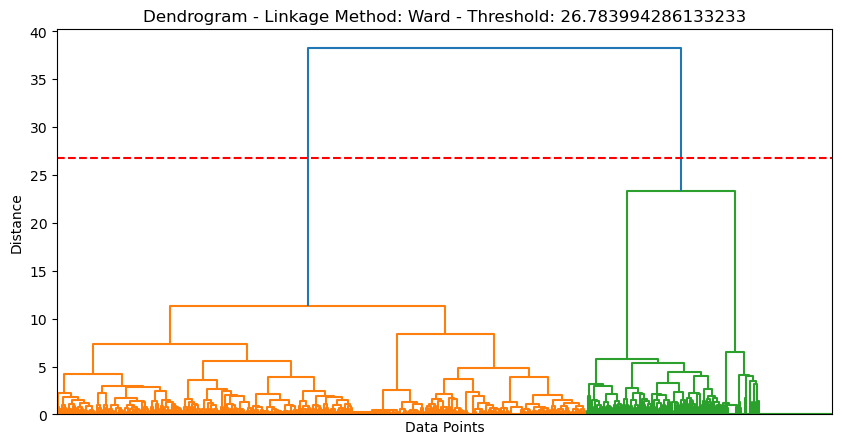

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Complete linkage:
[1 1 4 ... 1 4 6]

Number of clusters based on threshold: 6
SSE for Complete linkage: 392.21938860254306
Silhouette Score for Complete linkage: 0.4674514702968082
Calinski-Harabasz Score for Complete linkage: 485.2825462256286


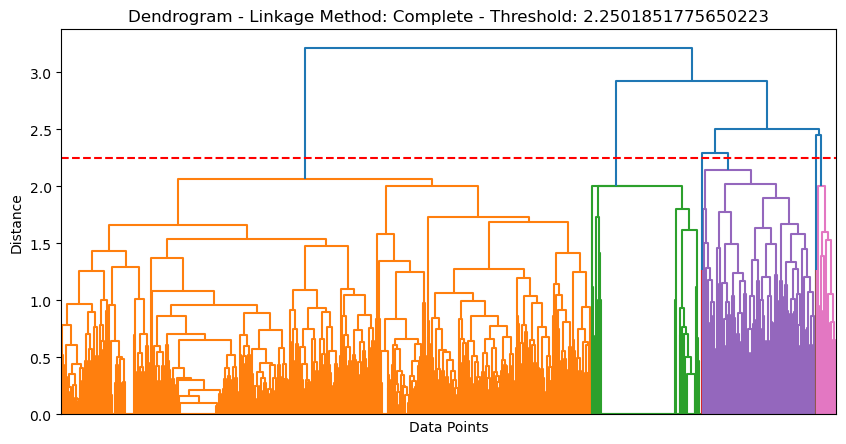

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Average linkage:
[2 2 5 ... 2 5 5]

Number of clusters based on threshold: 5
SSE for Average linkage: 417.659875874971
Silhouette Score for Average linkage: 0.4943711403022717
Calinski-Harabasz Score for Average linkage: 579.7008075169244


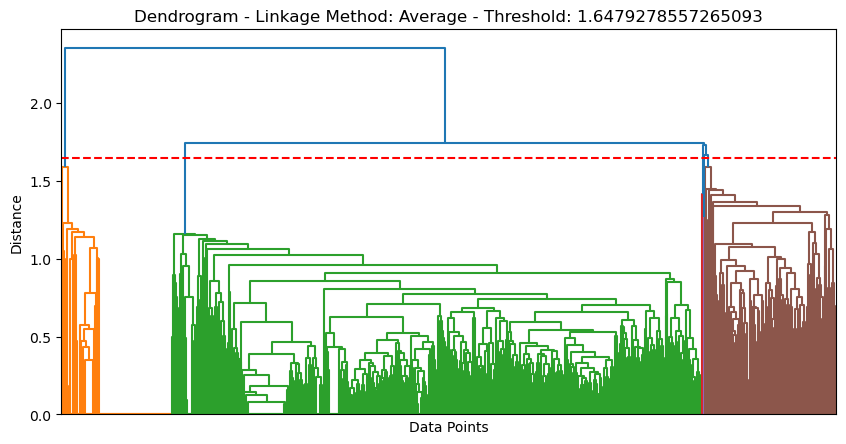

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Single linkage:
[12 12 13 ... 12 13 13]

Number of clusters based on threshold: 21
SSE for Single linkage: 237.42944606732587
Silhouette Score for Single linkage: 0.466081745133369
Calinski-Harabasz Score for Single linkage: 135.65175600720858


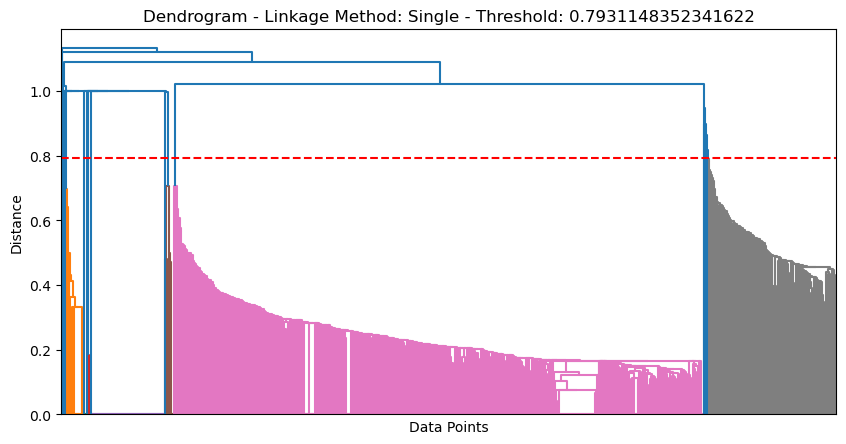

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Ward linkage:
[1 1 2 ... 1 2 2]

Number of clusters based on threshold: 2
SSE for Ward linkage: 808.9425695180853
Silhouette Score for Ward linkage: 0.4941219485599866
Calinski-Harabasz Score for Ward linkage: 1100.374446452293


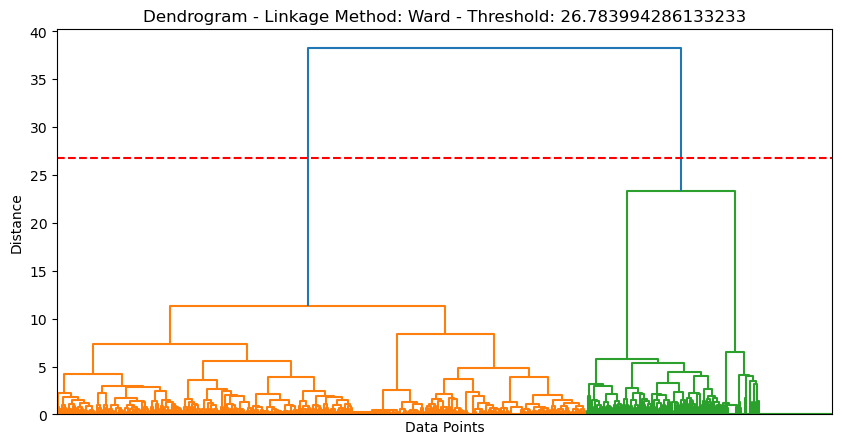

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Complete linkage:
[1 1 4 ... 1 4 6]

Number of clusters based on threshold: 6
SSE for Complete linkage: 392.21938860254306
Silhouette Score for Complete linkage: 0.4674514702968082
Calinski-Harabasz Score for Complete linkage: 485.2825462256286


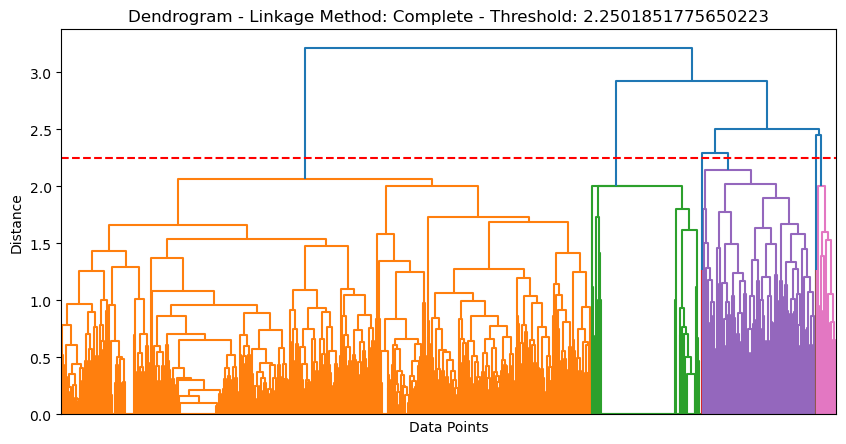

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Average linkage:
[2 2 5 ... 2 5 5]

Number of clusters based on threshold: 5
SSE for Average linkage: 417.659875874971
Silhouette Score for Average linkage: 0.4943711403022717
Calinski-Harabasz Score for Average linkage: 579.7008075169244


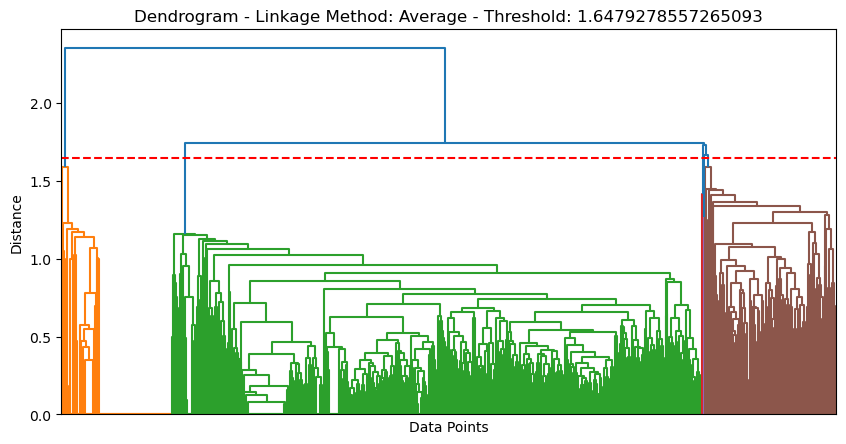

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Cluster labels using Single linkage:
[12 12 13 ... 12 13 13]

Number of clusters based on threshold: 21
SSE for Single linkage: 237.42944606732587
Silhouette Score for Single linkage: 0.466081745133369
Calinski-Harabasz Score for Single linkage: 135.65175600720858


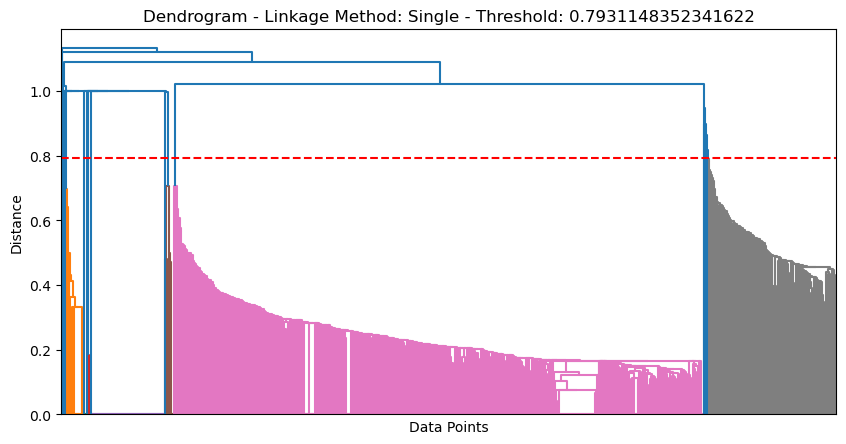

In [985]:

def compare_agglomerative_clustering(data_frame):
    n_clusters_lst=[]
    result = []
    data_array = data_frame.values
    linkage_methods = ['ward', 'complete', 'average', 'single']

    for method in linkage_methods:
        Z = linkage(data_array, method)

        max_d = Z[-1, 2]
        threshold = 0.7 * max_d

        cluster_assignments = fcluster(Z, threshold, criterion='distance')
        n_clusters = len(set(cluster_assignments))

        # SSE Calculation
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_array) 
        sse = kmeans.inertia_

        # Silhouette Score Calculation
        silhouette_avg = silhouette_score(data_array, cluster_assignments)

        # Additional Metric
        calinski_harabasz = calinski_harabasz_score(data_array, cluster_assignments)

        print(f'Cluster labels using {method.capitalize()} linkage:\n{cluster_assignments}\n{"="*40}\n')
        print(f'Number of clusters based on threshold: {n_clusters}')
        print(f'SSE for {method.capitalize()} linkage: {sse}')
        print(f'Silhouette Score for {method.capitalize()} linkage: {silhouette_avg}')
        print(f'Calinski-Harabasz Score for {method.capitalize()} linkage: {calinski_harabasz}')
        n_clusters_lst.append(n_clusters)
        result.append((n_clusters,sse,silhouette_avg,calinski_harabasz,method))
        # ציור גרף
        plt.figure(figsize=(10, 5))
        dendrogram(Z, labels=data_frame.index, orientation='top', leaf_rotation=90, leaf_font_size=8)
        plt.title(f'Dendrogram - Linkage Method: {method.capitalize()} - Threshold: {threshold}')
        plt.xlabel('Data Points')
        plt.ylabel('Distance')
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.axhline(y=threshold, color='r', linestyle='dashed')
        plt.show()
    return n_clusters_lst,result

n_clusters_lst= compare_agglomerative_clustering(emotions_df.iloc[:, 1:])[0]
results_lst=  compare_agglomerative_clustering(emotions_df.iloc[:, 1:])[1]  


In [987]:
df_result= pd.DataFrame(results_lst,columns=['n_clusters' ,'SSE','Silhouette','Calinski-Harabasz' ,'linkage_methods'])
df_result


,n_clusters,SSE,Silhouette,Calinski-Harabasz,linkage_methods
0,2,808.942570,0.494122,1100.374446,ward
1,6,392.219389,0.467451,485.282546,complete
2,5,417.659876,0.494371,579.700808,average
3,21,237.429446,0.466082,135.651756,single


In [997]:
# possible clusters
n_clusters_lst

[2, 6, 5, 21, 3]

## conclusions:
ההתלבטות בין חלוקה ל2 לבין חלוקה ל 5.

# k-means clustering


## find values for n_clusters

### using heat map & corr & Using networkx

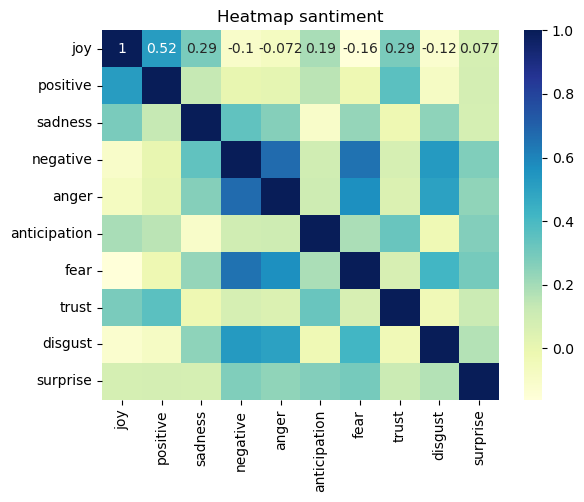

In [934]:
import seaborn as sns
sns.heatmap(emotions_df.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.title("Heatmap santiment")
plt.show()

In [935]:
treshold=0.3
# Find the correlation matrix
corr_matrix = emotions_df.iloc[:, 1:].corr()
# Sort the correlation matrix by absolute value of a column
for i in emotions_df.iloc[:, 1:].columns:
    sorted_corr_matrix = corr_matrix.sort_values(by=i, ascending=False)
    result=sorted_corr_matrix[i].iloc[np.where(sorted_corr_matrix[i]>treshold)].head(2)
    # Print the top correlations
    print("most related to",i,"are:\n\n",result,"\n")

most related to joy are:

 joy         1.000000
positive    0.520255
Name: joy, dtype: float64 

most related to positive are:

 positive    1.000000
joy         0.520255
Name: positive, dtype: float64 

most related to sadness are:

 sadness     1.000000
negative    0.344177
Name: sadness, dtype: float64 

most related to negative are:

 negative    1.000000
anger       0.670332
Name: negative, dtype: float64 

most related to anger are:

 anger       1.000000
negative    0.670332
Name: anger, dtype: float64 

most related to anticipation are:

 anticipation    1.000000
trust           0.327424
Name: anticipation, dtype: float64 

most related to fear are:

 fear        1.00000
negative    0.65101
Name: fear, dtype: float64 

most related to trust are:

 trust       1.000000
positive    0.357778
Name: trust, dtype: float64 

most related to disgust are:

 disgust     1.00000
negative    0.52922
Name: disgust, dtype: float64 

most related to surprise are:

 surprise    1.0
Name: surpr

In [936]:
g1=('joy','positive')
g2=('positive','joy')
g3=('sadness','negative')
g4=('negative','anger')
g5=('anger','negative')
g6 = ("anticipation","trust")
g7= ("fear","negative")
g8 =("trust","positive")
g9 = ("disgust","negative")
g10=('surprise','surprise')

Using networkx

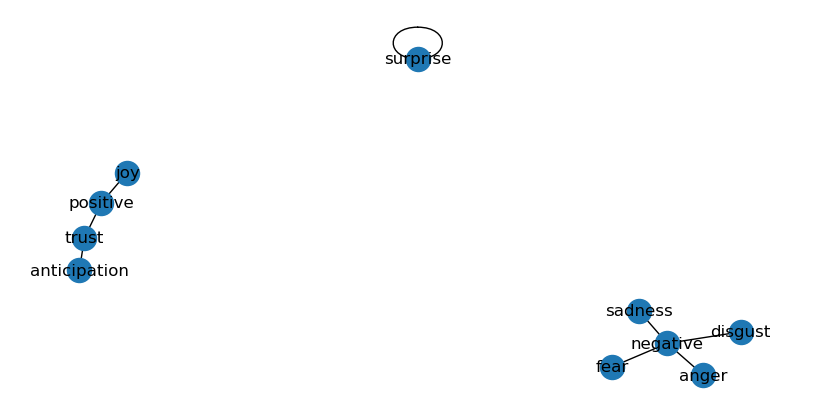

In [1134]:
import networkx as nx

# צור גרף
emotions = emotions_df.iloc[:,1:-1].columns
edges=[g1,g2,g3,g4,g5,g6,g7,g8,g9,g10]
G = nx.Graph()
G.add_nodes_from(emotions)
G.add_edges_from(edges)
    
# הפעל אלגוריתם Force-Directed Graph Layout
pos = nx.spring_layout(G)
    
# צייר את הגרף
import matplotlib.pyplot as plt
    
plt.figure(figsize=(8, 4))
nx.draw(G, pos, with_labels=True)
plt.show()


In [ ]:
print(df_result_Kmeans)

In [ ]:
שינוי קנה מידה של תכונות: נקה את התכונות לפני K-Means. זה יכול לעזור לאלגוריתם למצוא אשכולות טובים יותר אם תכונות שונות הן בקנה מידה שונה.



למה הכוונה?

In [1000]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, calinski_harabasz_score
sse_values = [] 
silhouette_values = [] 
calinski_harabasz_values = [] 
results_lst=[]
n_clusters_lst=[2,3,5]
for n_clusters in n_clusters_lst:
    km_model = KMeans(n_clusters=n_clusters, random_state=42)
    km_labels = km_model.fit_predict(emotions_df.iloc[:,1:])
    sse = km_model.inertia_
    sse_values.append(sse)
    silhouette_avg = silhouette_score(emotions_df.iloc[:,1:], km_labels)
    silhouette_values.append(silhouette_avg)

    # Calinski-Harabasz Score Calculation
    calinski_harabasz = calinski_harabasz_score(emotions_df.iloc[:,1:], km_labels)
    calinski_harabasz_values.append(calinski_harabasz) 
    results_lst.append((n_clusters,sse,silhouette_avg,calinski_harabasz))
    print(f"k-means with {n_clusters} clusters:")
    print(f"SSE: {sse}")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")
df_result_Kmeans= pd.DataFrame(results_lst,columns=['n_clusters' ,'SSE','Silhouette','Calinski-Harabasz'])
df_result_Kmeans

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


k-means with 2 clusters:
SSE: 808.9425695180853
Silhouette Score: 0.5158128227450882
Calinski-Harabasz Score: 1214.4878284057063


C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


k-means with 3 clusters:
SSE: 536.407147782932
Silhouette Score: 0.5206296221349229
Calinski-Harabasz Score: 1223.6726438060618


C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


k-means with 5 clusters:
SSE: 417.659875874971
Silhouette Score: 0.3172433590162106
Calinski-Harabasz Score: 870.716273081782


,n_clusters,SSE,Silhouette,Calinski-Harabasz
0,2,808.942570,0.515813,1214.487828
1,3,536.407148,0.520630,1223.672644
2,5,417.659876,0.317243,870.716273


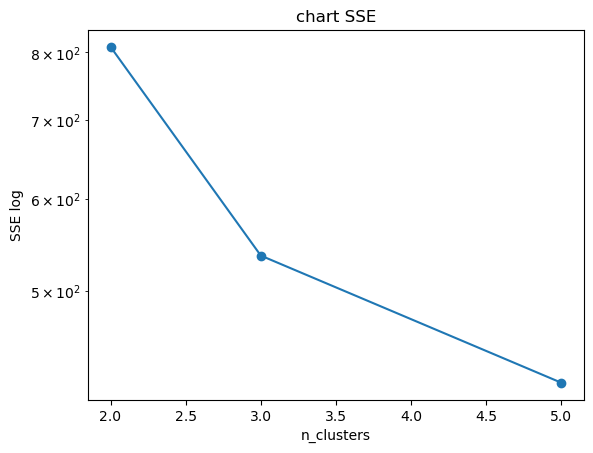

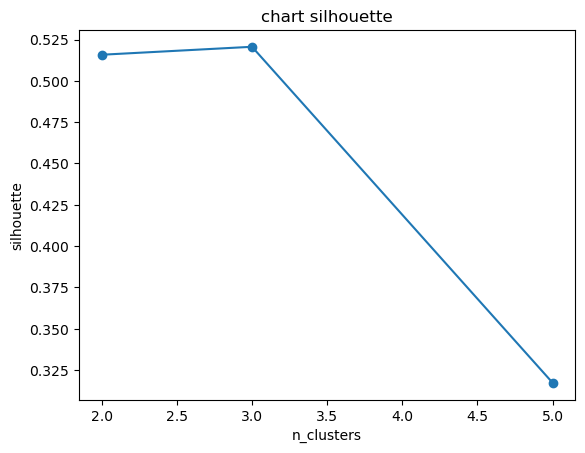

In [1002]:
plt.plot(n_clusters_lst, sse_values,marker='o')
plt.xlabel("n_clusters")
plt.ylabel("SSE log")
plt.yscale("log")
plt.title("chart SSE")
plt.show()



plt.plot(n_clusters_lst, silhouette_values,marker='o')
plt.xlabel("n_clusters")
plt.ylabel("silhouette")
plt.title("chart silhouette")
plt.show()


## conclusions
3 הכי טוב 
יש מרפק
ציונים טובים
יותר טוב מהתוצאות של ההירכי 

אם נרצה ויהיה זמן,ניתן לבדוק עם היפר פרמטרים שונים

In [1004]:
# קביעת מספר אשכולות
n_clusters = 3
# יצירת מודל KMeans
kmeans = KMeans(n_clusters=n_clusters)
# התאמת המודל לנתונים
kmeans.fit(emotions_df.iloc[:,1:])
# הוספת עמודת תיוג אשכולות
emotions_df["cluster_label"] = kmeans.labels_
clustered_data = emotions_df.groupby("cluster_label")
print(clustered_data.size())

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster_label
0    833
1    174
2    211
dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_10528\3041687580.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(clustered_data.get_group(i).iloc[:, 0], clustered_data.get_group(i).iloc[:, 1], c=colors[i], label=f"Cluster {i}")


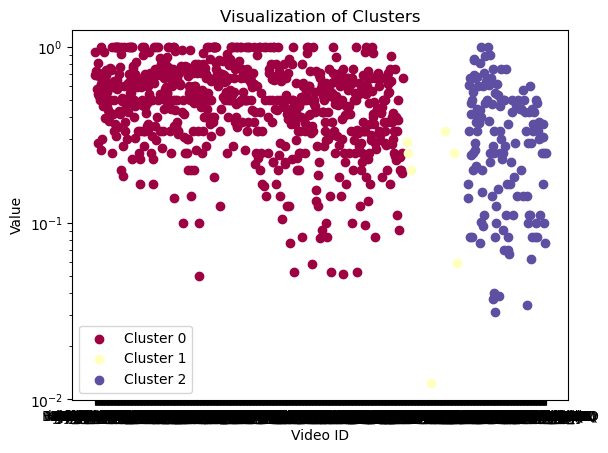

<Figure size 3000x1000 with 0 Axes>

In [1005]:
# צבעים שונים לכל אשכול
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))

# ציור נקודות לפי אשכול
for i in range(n_clusters):
    plt.scatter(clustered_data.get_group(i).iloc[:, 0], clustered_data.get_group(i).iloc[:, 1], c=colors[i], label=f"Cluster {i}")

# כותרות ותוויות
plt.title("Visualization of Clusters")
plt.xlabel("Video ID")
plt.ylabel("Value")
plt.yscale("log")
plt.legend()
plt.figure(figsize=(30, 10))

# הצגת התרשים
plt.show()

# DBSCAN

Silhouette Score: 0.46305710403317196
Calinski-Harabasz Score: 587.9492468290557


C:\Users\user\AppData\Local\Temp\ipykernel_10528\2933455584.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


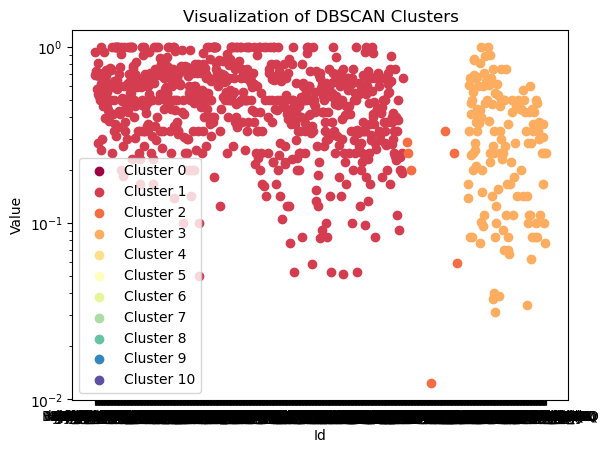

Silhouette Score: 0.44291016015943663
Calinski-Harabasz Score: 640.4028530948136


C:\Users\user\AppData\Local\Temp\ipykernel_10528\2933455584.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


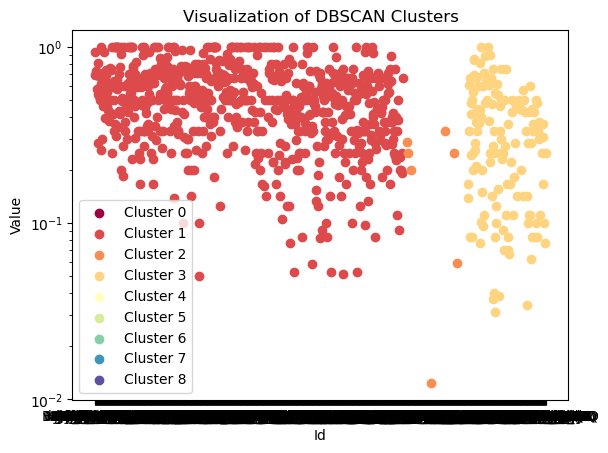

Silhouette Score: 0.40263924184199196
Calinski-Harabasz Score: 453.131065351479


C:\Users\user\AppData\Local\Temp\ipykernel_10528\2933455584.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


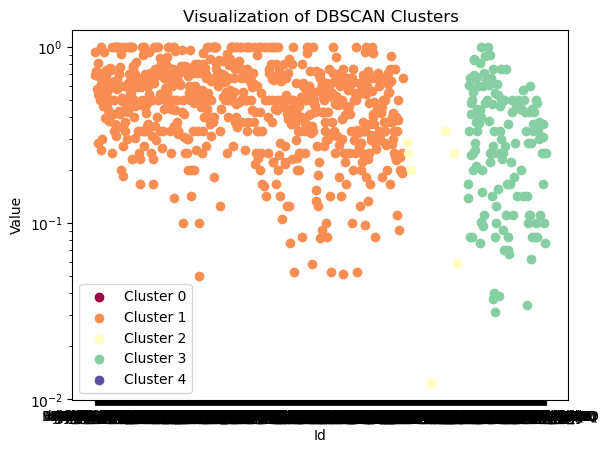

Silhouette Score: 0.5199857258116515
Calinski-Harabasz Score: 629.9936766477421


C:\Users\user\AppData\Local\Temp\ipykernel_10528\2933455584.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


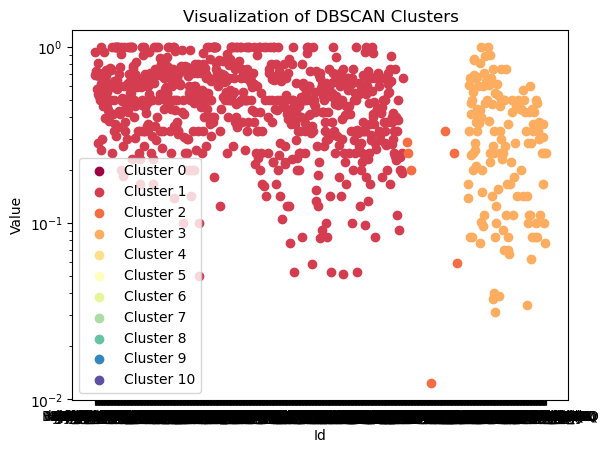

Silhouette Score: 0.5044363078597841
Calinski-Harabasz Score: 490.09406019109474


C:\Users\user\AppData\Local\Temp\ipykernel_10528\2933455584.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


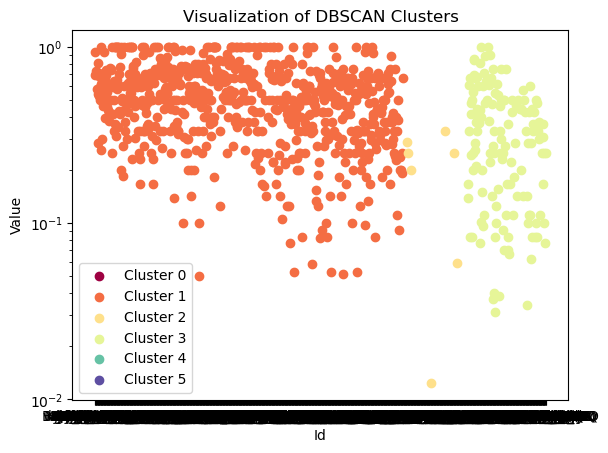

Silhouette Score: 0.4970202223743032
Calinski-Harabasz Score: 587.2395344821844


C:\Users\user\AppData\Local\Temp\ipykernel_10528\2933455584.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


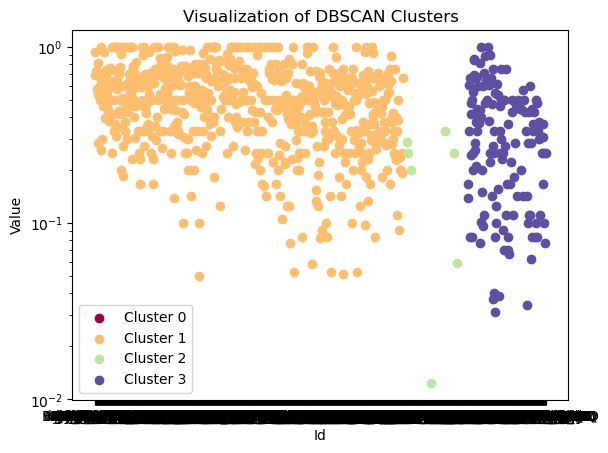

Silhouette Score: 0.535639231558869
Calinski-Harabasz Score: 569.3898483733268


C:\Users\user\AppData\Local\Temp\ipykernel_10528\2933455584.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


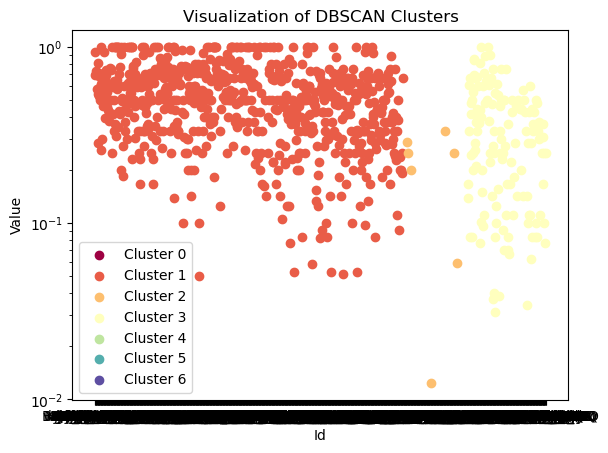

Silhouette Score: 0.5278056614932031
Calinski-Harabasz Score: 676.6030918718074


C:\Users\user\AppData\Local\Temp\ipykernel_10528\2933455584.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


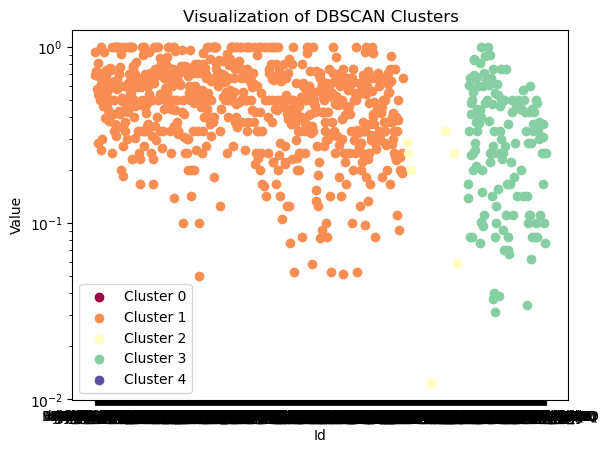

Silhouette Score: 0.5272960440785481
Calinski-Harabasz Score: 683.1592011005333


C:\Users\user\AppData\Local\Temp\ipykernel_10528\2933455584.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")


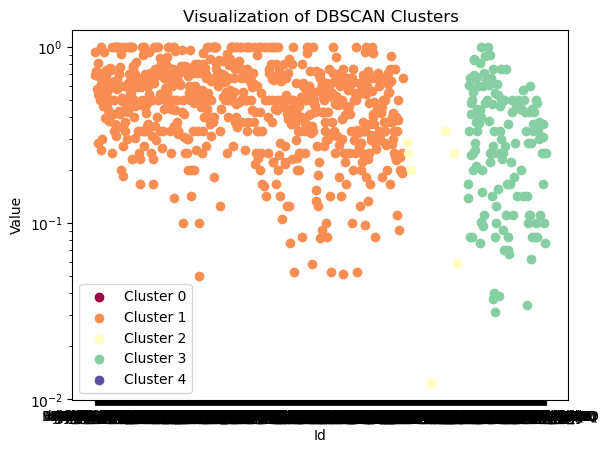

In [1011]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

def dbscan_clustering(data_frame, lst ,eps=0.5, min_samples=10):
    # יצירת מודל DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # התאמת המודל לנתונים
    labels = dbscan.fit_predict(data_frame.iloc[:, 1:])

    # הוספת עמודת תיוג אשכולות
    data_frame["cluster_label"] = labels

    # חישוב Silhouette Score
    silhouette_avg = silhouette_score(data_frame.iloc[:, 1:], labels)

    # חישוב Calinski-Harabasz Score
    calinski_harabasz = calinski_harabasz_score(data_frame.iloc[:, 1:], labels)
    # הדפסת תוצאות
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")

    # צבעים שונים לכל אשכול
    colors = plt.cm.Spectral(np.linspace(0, 1, len(np.unique(labels))))

    # ציור נקודות לפי אשכול
    for i, cluster_label in enumerate(np.unique(labels)):
        cluster_data = emotions_df[emotions_df['cluster_label'] == cluster_label]
        plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], c=colors[i], label=f"Cluster {i}")
    # כותרות ותוויות
    plt.title("Visualization of DBSCAN Clusters")
    plt.xlabel("Id")
    plt.ylabel("Value")
    plt.yscale("log")
    plt.legend()
    plt.show()
    lst.append((i+1,silhouette_avg,calinski_harabasz))

    return results_lst

    
eps_lst=[0.25,0.5,0.75]
min_samples_lst=[5,10,15]
results_lst=[]
# ביצוע DBSCAN
for eps in eps_lst:
    for min_samples in min_samples_lst:
        results_lst = dbscan_clustering(emotions_df.copy(), results_lst, eps, min_samples)


# conclusions
הבחירה ב5 היא הכי טובה וגם היא פחות טובה מ בחירה של 3 במודל K,EANS

In [1012]:
df_result_DBSCAN= pd.DataFrame(results_lst,columns=['n_clusters','Silhouette','Calinski-Harabasz'])
df_result_DBSCAN

,n_clusters,Silhouette,Calinski-Harabasz
0,11,0.463057,587.949247
1,9,0.442910,640.402853
2,5,0.402639,453.131065
3,11,0.519986,629.993677
4,6,0.504436,490.094060
5,4,0.497020,587.239534
6,7,0.535639,569.389848
7,5,0.527806,676.603092
8,5,0.527296,683.159201


# ניתוח תוצאות

### בחירת חלוקה ושמירה על csv

# THE BEST MODEL

In [1016]:
# קביעת מספר אשכולות
n_clusters = 3
# יצירת מודל KMeans
kmeans = KMeans(n_clusters=n_clusters)
# התאמת המודל לנתונים
kmeans.fit(emotions_df.iloc[:,1:])
# הוספת עמודת תיוג אשכולות
emotions_df["cluster_label"] = kmeans.labels_
clustered_data = emotions_df.groupby("cluster_label")
print(clustered_data.size())

C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


cluster_label
0    833
1    174
2    211
dtype: int64


In [1017]:
# Create separate CSV files
for i in range(n_clusters):
    c_data = emotions_df[emotions_df["cluster_label"] == i]
    c_data.to_csv(f'cluster_{i}.csv', index=False)

In [1018]:
c_0 = pd.read_csv('cluster_0.csv')
c_1 = pd.read_csv('cluster_1.csv')
c_2 = pd.read_csv('cluster_2.csv') 


In [1073]:
c_2.iloc[]

,Id,joy,positive,sadness,negative,anger,anticipation,fear,trust,disgust,surprise,cluster_label
0,mLW35YMzELE,0.166667,1.000000,0.500000,0.000000,0.833333,0.000000,0.833333,0.166667,0.000000,0.000000,2
1,3cbnNwxtUUA,0.137931,0.206897,0.206897,1.000000,0.068966,0.000000,0.862069,0.000000,0.034483,0.758621,2
2,t_4ob8SB2UI,0.609756,1.000000,0.487805,0.804878,0.365854,0.560976,0.243902,0.536585,0.000000,0.048780,2
3,pRpeEdMmmQ0,0.333333,0.666667,0.833333,0.833333,0.166667,1.000000,0.333333,0.666667,0.000000,0.000000,2
4,36vjwGx-Vzc,0.000000,0.222222,0.111111,1.000000,0.111111,0.000000,0.111111,0.000000,0.111111,0.888889,2
...,...,...,...,...,...,...,...,...,...,...,...,...
206,iP94Kjrf128,0.000000,1.000000,0.222222,0.888889,0.000000,0.000000,0.888889,0.111111,0.000000,0.000000,2
207,YLDQvDNK_WQ,0.000000,0.000000,0.375000,1.000000,0.500000,0.125000,0.625000,0.125000,0.000000,0.000000,2
208,oIm3m9sgthA,0.076923,1.000000,0.269231,0.576923,0.115385,0.384615,0.461538,0.384615,0.000000,0.153846,2
209,Wwd1sfHSwcQ,0.250000,0.750000,0.000000,1.000000,0.500000,0.250000,0.250000,0.000000,0.000000,0.500000,2


In [1174]:
em_lst={'positive': 'joy positive trust anticipation',
        'negative': 'negative sadness fear anger disgust',
        'surprise': 'surprise'
        }

the word cloud for cluster 0 is: 

frequencies_dict is: Counter({'positive': 79360, 'joy': 37622, 'trust': 32405, 'anticipation': 26019, 'sadness': 15333, 'negative': 10815, 'fear': 6537, 'anger': 5896, 'surprise': 5672, 'disgust': 1525}) 
positive: 175406 negative: 40106 surprise: 5672


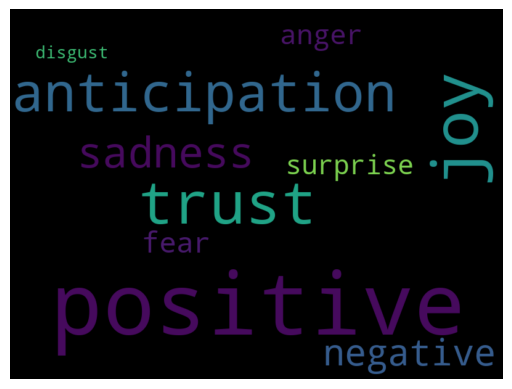

the word cloud for cluster 1 is: 

frequencies_dict is: Counter({'anticipation': 2976, 'sadness': 1052, 'trust': 984, 'negative': 794, 'fear': 760, 'positive': 680, 'joy': 415, 'surprise': 235, 'anger': 179, 'disgust': 125}) 
positive: 5055 negative: 2910 surprise: 235


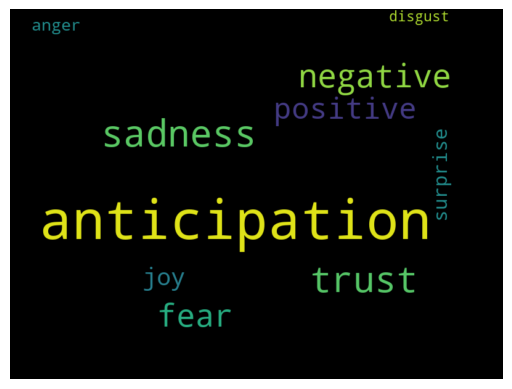

the word cloud for cluster 2 is: 

frequencies_dict is: Counter({'negative': 17189, 'positive': 15729, 'fear': 11873, 'sadness': 8276, 'anger': 7318, 'anticipation': 7232, 'trust': 6814, 'joy': 4924, 'disgust': 4021, 'surprise': 3472}) 
positive: 34699 negative: 48677 surprise: 3472


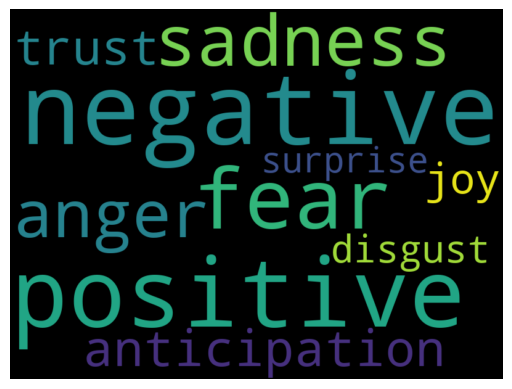

In [1183]:
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

lst_df = [c_0, c_1, c_2]  # רשימת ה-DataFrames שלך

# יצירת MinMaxScaler
scaler = MinMaxScaler()

cluster_num = 0
for cluster in lst_df:
    text = ''
    for col in cluster.iloc[:, 1:-1].columns:
        # התאמת נתוני העמודה ל-MinMaxScaler
        data_for_scaling = cluster[col].to_numpy().reshape(-1, 1)  

        # ביצוע הנורמליזציה
        scaled_data = scaler.fit_transform(data_for_scaling)  

        # המרת הטקסט בחזרה לרשימה
        scaled_values_list = scaled_data.reshape(-1).tolist()   

        # בניית תדירות מילים מנורמלת
        for value in scaled_values_list:
            text += int(value * 100) * (col + " ")  # שימוש ב'value * 100' למטרות תדירות 
    # יצירת ה-Wordcloud
    frequencies_dict = Counter(text.split())
    sum_p=0
    sum_neg=0
    sum_n=0
    for key,val in em_lst.items():
        for k,v in frequencies_dict.items():
            if k in em_lst[key] and key == 'positive':
                sum_p += v
            elif k in em_lst[key] and key == 'negative':
                sum_neg += v
            elif k in em_lst[key] and key == 'surprise':
                sum_n+= v
    wordcloud = WordCloud(width=800, height=600, min_word_length = 3, max_words=100, background_color="black") 
    wordcloud_image = wordcloud.generate_from_frequencies(frequencies_dict)
    print("the word cloud for cluster", cluster_num, "is:", '\n\nfrequencies_dict is:', frequencies_dict,"\npositive:",sum_p,'negative:',sum_neg,'surprise:',sum_n)
    plt.imshow(wordcloud_image, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    cluster_num += 1
